In [1]:
import pandas as pd
import numpy as np
from yieldCurvePrediction import yieldCurvePredictor
from Models.ECIR_new import ECIRModel
from Models.CIRModel import BasicCIRModel

In [65]:
class strategy:

    def __init__(self, model, dates, data):

        self.model = model
        self.dates = dates
        self.data = data

    def prices(self):

        mod_dict = {}
        price_dict = {}
        
        for date in self.dates:
    
            mod_dict[date] = yieldCurvePredictor(self.model, date, self.data) 
            price_dict[date] = mod_dict[date].comb_data()[1]
    
        return price_dict

    def buy_sell(self):

        prices = self.prices()
    
        for date in self.dates:
    
            bonds = []
        
            for bond in prices[date].index:
                if prices[date]['Simulated Prices'][bond] < prices[date]['Actual Prices'][bond]:
                    bonds.append(-1)
                else:
                   bonds.append(1)
            prices[date]['Buy?'] = bonds 

        return prices

    def profit(self, cash = 1000000):

        prices = self.buy_sell()
        weights = 1 / 5
        value = weights*cash
        invested = np.zeros(len(prices[self.dates[0]]))
        shares = np.zeros(len(prices[self.dates[0]]))
        profit = np.zeros(len(prices[self.dates[0]]))
        prices = self.buy_sell()
        
        for i in range(len(self.dates)):

            errs = pd.DataFrame({'Error' :np.abs(prices[self.dates[i]]['Actual Prices'] - prices[self.dates[i]]['Simulated Prices'])})

            errs = errs.sort_values(by = 'Error')
            errs['Invest?'] = np.zeros(len(errs))
            new_index = errs.index
            index_ones = new_index[:5]
            index_zeros = new_index[5:]
            errs['Invest?'][index_ones] = np.ones(5)
            errs['Invest?'][index_zeros] = np.zeros(len(errs) - 5)

            prices[dates[i]] = prices[dates[i]].join(errs)
            
            for j in range(len(prices[self.dates[i]]['Actual Prices'])):
                
                profit[j] += (shares[j] * prices[self.dates[i]]['Actual Prices'][j]) - invested[j]
                yesterday_invested = np.sum(invested)
                
                shares[j] = np.floor(value / prices[self.dates[i]]['Actual Prices'][j]) * prices[self.dates[i]]['Invest?'][j]
                invested[j] = (shares[j] * prices[self.dates[i]]['Actual Prices'][j]) * prices[self.dates[i]]['Invest?'][j]
                
                if prices[self.dates[i]]['Buy?'][j] == -1:
                    invested[j] *= -1
                    shares[j] *= -1
        
            cash += (np.sum(profit) + yesterday_invested - np.sum(invested))
            value = weights*cash

        return pd.DataFrame({'Profit' : profit}).set_index(prices[dates[0]].index)

In [66]:
# Load the DGS_30 data
dgs_30_data = pd.read_csv('Data Folder/DGS_30.csv')
# Load the DGS3MO data
dgs3mo_data = pd.read_csv('Data Folder/DGS3MO.csv')

# Convert the 'DATE' column to datetime and set it as index for both DataFrames
dgs_30_data.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
dgs_30_data['Date'] = pd.to_datetime(dgs_30_data['Date'])
dgs_30_data.set_index('Date', inplace=True)

dgs3mo_data.rename(columns={'DATE': 'Date'}, inplace=True)
dgs3mo_data['Date'] = pd.to_datetime(dgs3mo_data['Date'])
dgs3mo_data.set_index('Date', inplace=True)

# Insert the DGS3MO data into the DGS_30 data as the first column
dgs_30_data.insert(0, 'DGS3MO', dgs3mo_data['DGS3MO'])

data=dgs_30_data

dates = data.loc[data.index >= '2024-03-15'].index

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# YIELD CURVE RESULTS

In [68]:
params_ecir = {
    "kappa": 3.071,    
    "mu_r": 0.007668,     
    "sigma": 0.3419,    
    "mu": 0.08226,      
    "gamma": 0.04355            
}

params_cir = {
    'kappa': 1.2310,
    'mu_r': 0.0459,
    'sigma': 0.1410
}

cir_ann = []
ecir_ann = []
all_profs = []

for i in range(100):
    CIR = strategy(BasicCIRModel(**params_cir), dates, data)
    ECIR = strategy(ECIRModel(**params_ecir), dates, data)
            
    CIR_profit = CIR.profit(1000000).rename(columns = {'Profit' : 'CIR'})
    ECIR_profit = ECIR.profit(1000000).rename(columns = {'Profit' : 'ECIR'})
    
    profits = pd.concat([CIR_profit, ECIR_profit], axis = 1)

    cir_ann.append((np.sum(profits)*100*12/1000000)[0])
    ecir_ann.append((np.sum(profits)*100*12/1000000)[1])
    print(cir_ann[-1])
    print(ecir_ann[-1])
    all_profs.append(profits)

2.8143167282614856
-0.8824032013528166
2.654360924404033
-0.42142809425632005
2.903465107029013
-0.35623147514294834
2.456819502797315
0.7174247392919264
2.7967083628189866
-0.24159300810933346
2.7129843502088797
0.12430678294004174
2.689631652091385
-0.6410556429477059
2.609414859373926
0.3807249859798816
2.508107547551114
-0.31920630522117716
2.441259350456286
0.3014461436005309
2.602441556546604
0.31582667625707106
2.621331123609119
0.6840360411466215
2.5883622733925584
-0.0820698990269797
2.836381117364473
-0.7393612778141861
2.6450829823012
0.46752888119963465
2.3706152435909025
0.44689784717647124
2.7194226827188626
0.2637171914017992
2.3517176132505875
-0.5852479419082404
2.635487585924857
-0.0681866690712981
3.068290113279456
0.14890351350725395
2.9082056086919734
-0.30053200923112455
2.6407698966306286
0.041058791376301085
2.730114351929049
-0.4392750656218152
2.8276269738639703
0.18687581485791596
2.738180979607883
-0.2295260717394878
2.578734752700571
-0.230592154805304
2.63

Text(0.5, 0, 'Annualized Profit (%)')

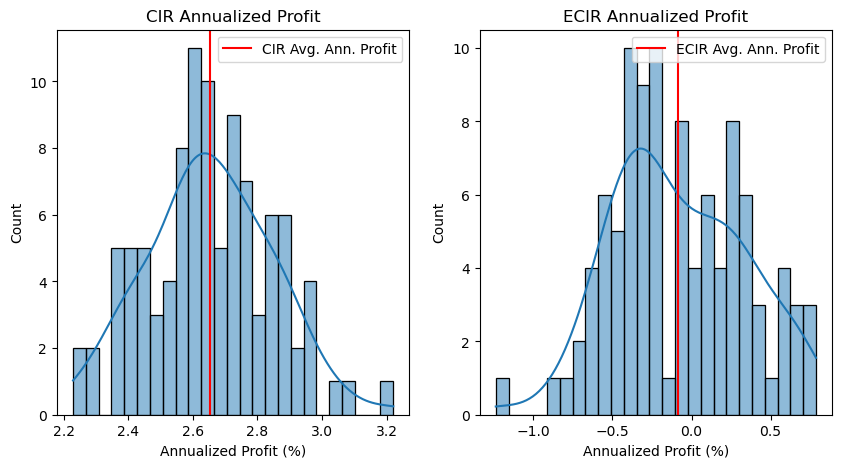

In [118]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
sns.histplot(cir_ann, bins = 25, kde = True)
plt.axvline(np.mean(cir_ann), color = 'red', label = 'CIR Avg. Ann. Profit')
plt.legend()
plt.title('CIR Annualized Profit')
plt.xlabel('Annualized Profit (%)')
plt.subplot(1, 2, 2)
sns.histplot(ecir_ann, bins = 25, kde = True)
plt.axvline(np.mean(ecir_ann), color = 'red', label = 'ECIR Avg. Ann. Profit')
plt.legend()
plt.title('ECIR Annualized Profit')
plt.xlabel('Annualized Profit (%)')

In [119]:
print('CIR Average Annualized Profit:', str(round(np.mean(cir_ann), 2)), '%')
print('ECIR Average Annualized Profit:', str(round(np.mean(ecir_ann), 2)), '%')

CIR Average Annualized Profit: 2.65 %
ECIR Average Annualized Profit: -0.08 %


In [120]:
all_cir = pd.DataFrame()
all_ecir = pd.DataFrame()
for i in range(len(all_profs)):
    all_cir[i] = all_profs[i]['CIR']
    all_ecir[i] = all_profs[i]['ECIR']

all_cir = all_cir.transpose()
all_ecir = all_ecir.transpose()

In [121]:
avg_cir_ind = np.mean(all_cir)*100*12/1000000
avg_ecir_ind = np.mean(all_ecir)*100*12/1000000

C:\Users\hanna\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\hanna\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [122]:
prof_ind = pd.DataFrame()

prof_ind['CIR'] = avg_cir_ind
prof_ind['ECIR'] = avg_ecir_ind

In [123]:
prof_ind['DGS3MO':'DGS15'].transpose().style.format(precision = 4).applymap(lambda x: 'background-color : yellow' if x==0 else '')

,DGS3MO,DGS1,DGS2,DGS3,DGS4,DGS5,DGS6,DGS7,DGS8,DGS9,DGS10,DGS11,DGS12,DGS13,DGS14,DGS15
CIR,0.0035,0.1785,-0.0603,-0.1694,0.0729,0.0000,0.0000,0.0221,-0.0120,-0.0009,0.0000,0.0000,0.0000,-0.0210,-0.0415,-0.0572
ECIR,0.0069,0.0001,-0.0080,0.0141,0.0124,-0.0065,-0.0023,0.0170,0.0010,-0.0039,0.0022,-0.0069,-0.0016,-0.0085,0.0163,-0.0162


In [124]:
prof_ind['DGS16':].transpose().style.format(precision = 4).applymap(lambda x: 'background-color : yellow' if x==0 else '')

,DGS16,DGS17,DGS18,DGS19,DGS20,DGS21,DGS22,DGS23,DGS24,DGS25,DGS26,DGS27,DGS28,DGS29,DGS30
CIR,-0.0295,-0.0007,-0.0017,-0.0021,0.0513,-0.0485,0.0232,0.0722,0.2766,0.4636,0.6129,0.5716,0.4141,0.2274,0.1076
ECIR,-0.0066,0.0065,-0.0043,-0.0114,-0.0164,0.0024,-0.0256,-0.0007,-0.0090,0.0016,-0.0107,0.0059,-0.0117,-0.0113,-0.0071


In [130]:
print('CIR Sharpe Ratio: ' + str(round((np.sum(np.mean(all_cir)) - 5.16) / np.sum(np.std(all_cir)), 3)))
print('ECIR Sharpe Ratio: ' + str(round((np.sum(np.mean(all_ecir)) - 5.16) / np.sum(np.std(all_ecir)), 3)))

CIR Sharpe Ratio: 1.624
ECIR Sharpe Ratio: -0.037


C:\Users\hanna\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\hanna\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
